In [1]:
%matplotlib inline
import xmitgcm
import xgcm
import xarray as xr
import matplotlib.pyplot as plt
import numpy as np

/home/spencerj/.conda/envs/tracers/lib/python3.6/site-packages/dask/config.py:168: YAMLLoadWarning: calling yaml.load() without Loader=... is deprecated, as the default Loader is unsafe. Please read https://msg.pyyaml.org/load for full details.
  data = yaml.load(f.read()) or {}
/home/spencerj/.conda/envs/tracers/lib/python3.6/site-packages/distributed/config.py:20: YAMLLoadWarning: calling yaml.load() without Loader=... is deprecated, as the default Loader is unsafe. Please read https://msg.pyyaml.org/load for full details.
  defaults = yaml.load(f)


In [2]:
datadir='tracer/kh_50'
iters=range(54150000,54300000,150000)
prefixes=['layersDiags','dyn']
ds=xmitgcm.open_mdsdataset(datadir,prefix=prefixes,iters=iters)
grid = xgcm.Grid(ds, periodic=['X'])
ds

<xarray.Dataset>
Dimensions:               (XC: 216, XG: 216, YC: 144, YG: 144, Z: 32, Zl: 32, Zp1: 33, Zu: 32, layer_1RHO_bounds: 37, layer_1RHO_center: 36, layer_1RHO_interface: 35, time: 1)
Coordinates:
    iter                  (time) int64 54150000
  * time                  (time) int64 54150000
  * XC                    (XC) >f4 0.4861 1.4583 2.4305 ... 208.5369 209.5091
  * YC                    (YC) >f4 -69.5139 -68.5417 ... 68.5385 69.5107
  * XG                    (XG) >f4 0.0 0.9722 1.9444 ... 208.0508 209.023
  * YG                    (YG) >f4 -70.0 -69.0278 -68.0556 ... 68.0524 69.0246
  * Z                     (Z) >f4 -6.7967243 -21.3834 ... -3572.361 -3857.0378
  * Zp1                   (Zp1) >f4 0.0 -13.593449 ... -3714.0034 -4000.0723
  * Zu                    (Zu) >f4 -13.593449 -29.173353 ... -4000.0723
  * Zl                    (Zl) >f4 0.0 -13.593449 ... -3430.7188 -3714.0034
    rA                    (YC, XC) >f4 dask.array<shape=(144, 216), chunksize=(144, 216)>


In [3]:
#positive=(ds.LaHs1RHO*ds.dxG).mean('time')>grid.interp((ds.Depth),'Y')
#positive2=grid.interp((ds.LaHs1RHO*ds.dxG).mean('time'),'1RHO',boundary='fill')>grid.interp((ds.Depth),'Y')
layers_depth_pac = (grid.cumsum((ds.LaHs1RHO*ds.dxG).mean('time').where(ds.XC<140).sum('XC')/ds.dxG.where(ds.XC<140).sum('XC'), '1RHO',         
                                    boundary='fill').load())
layers_depth_atl=(grid.cumsum((ds.LaHs1RHO*ds.dxG).mean('time').where(ds.XC>140).sum('XC')/ds.dxG.where(ds.XC>140).sum('XC'), '1RHO', 
                                  boundary='fill').load())
layers_depth=grid.cumsum(ds.LaHs1RHO.mean('time').mean('XC'), '1RHO', boundary='fill').load()
layers_depth_atlmix=xr.concat([layers_depth[:,0:36], layers_depth_atl[:,36:144]],'YG')
layers_depth_pacmix=xr.concat([layers_depth[:,0:36], layers_depth_pac[:,36:144]],'YG')
layers_depth_pacmix=layers_depth_pacmix.where(xr.ufuncs.isfinite(layers_depth_pacmix),0)
layers_depth_atlmix=layers_depth_atlmix.where(xr.ufuncs.isfinite(layers_depth_atlmix),0)
layers_depth_pacmix=layers_depth_pacmix.where((layers_depth_pacmix>0)|((layers_depth_pacmix.layer_1RHO_bounds<34)|(layers_depth_pacmix.YG<-60)), 4000)
layers_depth_atlmix=layers_depth_pacmix.where((layers_depth_atlmix>0)|((layers_depth_atlmix.layer_1RHO_bounds<34)|(layers_depth_atlmix.YG<-60)), 4000)


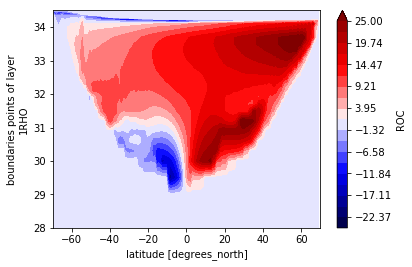

In [4]:
ROC_pac=grid.cumsum((ds.LaVH1RHO[:,:,:,0:139]*ds.dxG[:,0:139]).mean('time').sum('XC'),'1RHO',boundary='fill').load()
ROC_atl=grid.cumsum((ds.LaVH1RHO[:,:,:,140:215]*ds.dxG[:,140:215]).mean('time').sum('XC'),'1RHO',boundary='fill').load()
ROC_tot=grid.cumsum((ds.LaVH1RHO*ds.dxG).mean('time').sum('XC'),'1RHO',boundary='fill').load()
ROC_tot.name='ROC'
ROC_atl.name='ROC'
ROC_pac.name='ROC'
(ROC_tot/10**6).plot.contourf(x='YG',y='layer_1RHO_bounds',vmin=-25,vmax=25,xlim=(-70,70),levels=20,cmap='seismic')
#layers_depth_pacmix.plot.contour(levels=42)
#b.coords['depth'].plot.contour(levels=42)

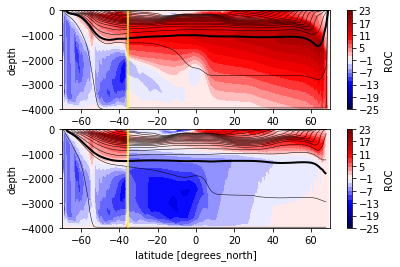

In [5]:
fig = plt.figure()
plt.subplot(2, 1, 1)
b = ROC_atl.copy()
b[:,0:35]=ROC_tot[:,0:35].copy()
b.coords['depth']=-layers_depth_atlmix
(b/10**6).plot.contourf(x='YG',y='depth',vmin=-25,vmax=25,xlim=(-70,70),ylim=(-4000,0),levels=np.arange(-25,25,2), cmap='seismic')
layer_1RHO_center_new = xr.DataArray(layers_depth_atl, dims=['layer_1RHO_bounds','YG'], coords={'layer_1RHO_bounds': ds.layer_1RHO_bounds,'YG':ds.YG})
layer2D,_=(xr.broadcast(-9.81*(ds.layer_1RHO_bounds-35)/1035, ds.YG))
layer2D.coords['depth']=(-layer_1RHO_center_new)
layer2D.plot.contour(x='YG',y='depth',levels=np.arange(0,0.04,0.002),colors='black',linewidths=0.5)
layer2D.plot.contour(x='YG',y='depth',levels=np.arange(0.0085,0.4,0.2),colors='black',linewidths=2)
plt.axvline(x=-35.5,color='yellow')

plt.subplot(2, 1, 2)
b = ROC_pac.copy()
b[:,0:35]=ROC_tot[:,0:35].copy()
b.coords['depth']=-layers_depth_pacmix
(b/10**6).plot.contourf(x='YG',y='depth',vmin=-25,vmax=25,xlim=(-70,70),ylim=(-4000,0),levels=np.arange(-25,25,2),cmap='seismic')
layer_1RHO_center_new = xr.DataArray(layers_depth_pac, dims=['layer_1RHO_bounds','YG'], coords={'layer_1RHO_bounds': ds.layer_1RHO_bounds,'YG':ds.YG})
layer2D,_=(xr.broadcast(-9.81*(ds.layer_1RHO_bounds-35)/1035, ds.YG))
layer2D.coords['depth']=(-layer_1RHO_center_new)
layer2D=layer2D.where(layer2D.YG<69)
layer2D.plot.contour(x='YG',y='depth',levels=np.arange(0,0.04,0.002),colors='black',linewidths=0.5)
layer2D.plot.contour(x='YG',y='depth',levels=np.arange(0.0085,0.4,0.2),colors='black',linewidths=2)
plt.axvline(x=-35.5,color='yellow')
fig.savefig('../tracer_figs/ROC.eps', bbox_inches='tight')

/home/spencerj/.conda/envs/tracers/lib/python3.6/site-packages/dask/core.py:119: RuntimeWarning: invalid value encountered in true_divide
  return func(*args2)
/home/spencerj/.conda/envs/tracers/lib/python3.6/site-packages/dask/array/numpy_compat.py:28: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)


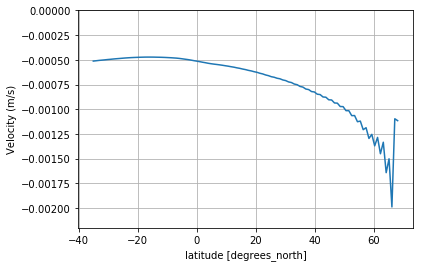

In [13]:
fig,ax=plt.subplots(1,1)
(ds.LaVH1RHO[:,21:-1,36:-1,140:215].sum('layer_1RHO_center')/ds.LaHs1RHO[:,21:-1,36:-1,140:215].sum('layer_1RHO_center')).mean('time').mean('XC').plot()
ax.set_ylabel('Velocity (m/s)')
ax.set_ylim(-0.0022,0)
ax.grid(True)

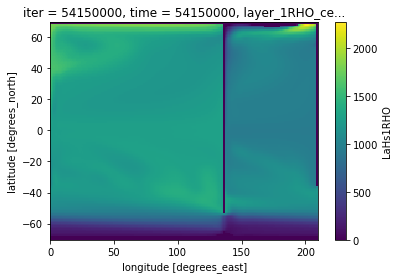

In [17]:
ds.LaHs1RHO.cumsum('layer_1RHO_center')[0,20,:,:].plot()